In [5]:
!pip install --upgrade pip seaborn -q

In [6]:
USE_GPU = True

In [7]:
if USE_GPU:
    import pandas as cpu_pd
    import dask_cudf as dd
    import cudf as pd
    file_path = 'frequency_encoded_data'
else:
    import pandas as pd
    import dask.dataframe as dd
    file_path = '../../datasets/frequency_encoded_data'

import seaborn as sns
import numpy as cpu_np
import glob

In [8]:
parquet_files = glob.glob(file_path + '/*.parquet')
parquet_files = sorted(parquet_files)

In [9]:
df = dd.read_parquet(parquet_files).compute()

In [10]:
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values(['date_time']).reset_index(drop=True)

In [11]:
tasks_per_session = df.groupby(['user_id', 'session_30'])['date_time'].count().reset_index().rename(columns={'date_time': 'tasks_per_session'}).to_pandas()
# summary of question
tasks_per_session['tasks_per_session'].describe()

count    650539.000000
mean         59.183216
std         160.675861
min           1.000000
25%           4.000000
50%          15.000000
75%          51.000000
max       12461.000000
Name: tasks_per_session, dtype: float64

In [12]:
greater_1000 = tasks_per_session[tasks_per_session['tasks_per_session'] > 1000]
less_100 = tasks_per_session[tasks_per_session['tasks_per_session'] < 100]
less_50 = tasks_per_session[tasks_per_session['tasks_per_session'] < 50]
less_25 = tasks_per_session[tasks_per_session['tasks_per_session'] < 25]
display(f'greater 1000: {greater_1000.shape[0]}: perc {greater_1000.shape[0] / tasks_per_session.shape[0]}')
display(f'less 100: {less_100.shape[0]}: perc {less_100.shape[0] / tasks_per_session.shape[0]}')
display(f'less 50: {tasks_per_session[tasks_per_session["tasks_per_session"] < 50].shape[0]}: perc {tasks_per_session[tasks_per_session["tasks_per_session"] < 50].shape[0] / tasks_per_session.shape[0]}')
display(f'less 25: {tasks_per_session[tasks_per_session["tasks_per_session"] < 25].shape[0]}: perc {tasks_per_session[tasks_per_session["tasks_per_session"] < 25].shape[0] / tasks_per_session.shape[0]}')

'greater 1000: 2953: perc 0.004539312785244236'

'less 100: 557702: perc 0.8572921838659942'

'less 50: 483917: perc 0.7438708517091212'

'less 25: 391817: perc 0.6022959422878567'

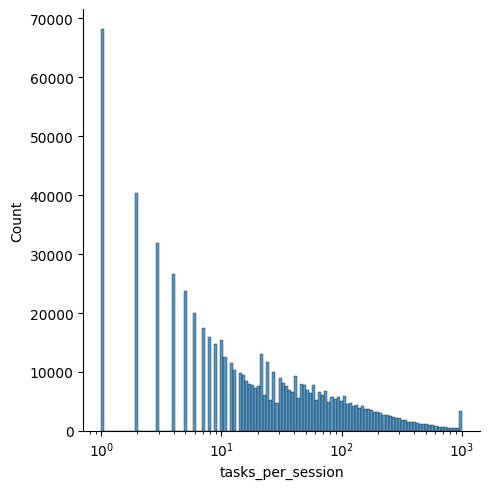

In [13]:
tasks_per_session['tasks_per_session'] =  tasks_per_session['tasks_per_session'].clip(upper=1000)
sns.displot(tasks_per_session['tasks_per_session'], common_bins=False, common_norm=False, log_scale=True)

In [14]:
# time within session
elapsed_time_per_session = df.groupby(['user_id', 'session_30'])['date_time'].agg(['min', 'max']).reset_index().to_pandas()
elapsed_time_per_session['total_time'] = elapsed_time_per_session['max'] - elapsed_time_per_session['min']
elapsed_time_per_session['total_mins'] = elapsed_time_per_session['total_time'].dt.total_seconds() / 60

In [15]:
elapsed_time_per_session['total_mins'].describe()

count    650539.000000
mean         28.776690
std          40.305159
min           0.000000
25%           3.633333
50%          15.583333
75%          37.966667
max        1107.466667
Name: total_mins, dtype: float64

In [16]:
sub_15_mins = elapsed_time_per_session[elapsed_time_per_session['total_mins'] < 15]
sub_30_mins = elapsed_time_per_session[elapsed_time_per_session['total_mins'] < 30]
sub_60_mins = elapsed_time_per_session[elapsed_time_per_session['total_mins'] < 60]
sub_120_mins = elapsed_time_per_session[elapsed_time_per_session['total_mins'] < 120]
sub_180_mins = elapsed_time_per_session[elapsed_time_per_session['total_mins'] < 180]
display(f'less 15 mins: {sub_15_mins.shape[0]}: perc {sub_15_mins.shape[0] / elapsed_time_per_session.shape[0]}')
display(f'less 30 mins: {sub_30_mins.shape[0]}: perc {sub_30_mins.shape[0] / elapsed_time_per_session.shape[0]}')
display(f'less 60 mins: {sub_60_mins.shape[0]}: perc {sub_60_mins.shape[0] / elapsed_time_per_session.shape[0]}')
display(f'less 120 mins: {sub_120_mins.shape[0]}: perc {sub_120_mins.shape[0] / elapsed_time_per_session.shape[0]}')
display(f'less 180 mins: {sub_180_mins.shape[0]}: perc {sub_180_mins.shape[0] / elapsed_time_per_session.shape[0]}')

'less 15 mins: 319031: perc 0.4904102597999505'

'less 30 mins: 443851: perc 0.6822819231437316'

'less 60 mins: 564697: perc 0.8680448059224736'

'less 120 mins: 628167: perc 0.965610055661536'

'less 180 mins: 641657: perc 0.9863467063465834'

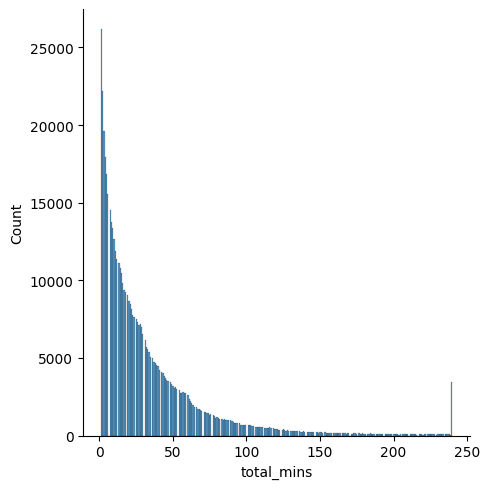

In [17]:
elapsed_time_per_session['total_mins'] = elapsed_time_per_session['total_mins'].clip(upper=240)
elapsed_time_per_session['total_mins'] = elapsed_time_per_session['total_mins'].astype(int)
elapsed_time_per_session = elapsed_time_per_session[elapsed_time_per_session['total_mins'] > 0]
sns.displot(elapsed_time_per_session['total_mins'])

In [18]:
time_between_sessions = df.groupby(['user_id', 'session_30'])['date_time'].agg(['min', 'max']).reset_index().to_pandas().reset_index()

In [19]:
time_between_sessions = time_between_sessions.sort_values(['min']).reset_index(drop=True)
time_between_sessions['prev_session_end'] = time_between_sessions.groupby(['user_id'])['max'].shift(1)
time_between_sessions = time_between_sessions.dropna().reset_index(drop=True)

In [20]:
time_between_sessions['minutes_between_sessions'] = (time_between_sessions['min'] - time_between_sessions['prev_session_end']).dt.total_seconds() / 60

In [21]:
less_45 = time_between_sessions[time_between_sessions['minutes_between_sessions'] < 45]
less_60 = time_between_sessions[time_between_sessions['minutes_between_sessions'] < 60]
less_120 = time_between_sessions[time_between_sessions['minutes_between_sessions'] < 120]
less_720 = time_between_sessions[time_between_sessions['minutes_between_sessions'] < 720]
less_1440 = time_between_sessions[time_between_sessions['minutes_between_sessions'] < 1440]
less_2160 = time_between_sessions[time_between_sessions['minutes_between_sessions'] < 2160]
display(f'less 45 mins: {less_45.shape[0]}: perc {less_45.shape[0] / time_between_sessions.shape[0]}')
display(f'less 60 mins: {less_60.shape[0]}: perc {less_60.shape[0] / time_between_sessions.shape[0]}')
display(f'less 120 mins: {less_120.shape[0]}: perc {less_120.shape[0] / time_between_sessions.shape[0]}')
display(f'less 720 mins: {less_720.shape[0]}: perc {less_720.shape[0] / time_between_sessions.shape[0]}')
display(f'less 1440 mins: {less_1440.shape[0]}: perc {less_1440.shape[0] / time_between_sessions.shape[0]}')
display(f'less 2160 mins: {less_2160.shape[0]}: perc {less_2160.shape[0] / time_between_sessions.shape[0]}')

'less 45 mins: 51579: perc 0.0945025146804203'

'less 60 mins: 81447: perc 0.14922635788162222'

'less 120 mins: 142276: perc 0.2606766276715617'

'less 720 mins: 250255: perc 0.4585146437765095'

'less 1440 mins: 368283: perc 0.6747643345944906'

'less 2160 mins: 401987: perc 0.7365164576443537'

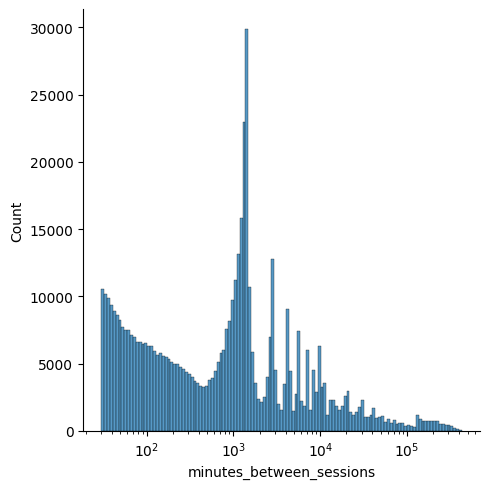

In [22]:
sns.displot(time_between_sessions['minutes_between_sessions'], common_bins=False, common_norm=(False, True), log_scale=True)